### Code for the paper "*A Deep Learning Algorithm Predicts Milk Yield and Production Stage of Dairy Cows utilizing Ultrasound Echotexture 3 Analysis of the Mammary Gland*"

It presents the model construction and the produced results for the Late Lactation - Peak Lactation binary classification problem.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Reading the file containing labeling info. The "name" column corresponds to an animal and the "dmy" column corresponds to the animal's milk yield.

In [2]:
df = pd.read_csv("milk_yield_labels.csv")

# Delete unnecessary column and rename the columns.
del df['Unnamed: 2'] 
df = df.rename(columns={'Cow': 'name', 'DMY':'dmy'})

print("Length of dataframe containing labeling info: ",len(df))
df.head()

Length of dataframe containing labeling info:  384


,name,dmy
0,2121_1,26.8
1,2137_1,31.2
2,2112_1,27.2
3,2144_1,23.1
4,2136_1,31.1


Reading the echotexture variable dataset. Each row contains the echotecture variables retrieved from the ultrasound images associated with the "name" variable.

In [3]:
df_features = pd.read_csv("echotexture_features.csv")
print ("Length of dataframe containing features: ",len(df_features))
# Deleting unnecessary column
del df_features['Unnamed: 0'] 
df_features.head()

Length of dataframe containing features:  2960


,name,Size_of_ROIs,Mean_Value,St._Deviation,Skewness,Excess,0.05_Quantil,0.95_Quantil,Gradient_Mean_value,Gradient_Variance,Percentage_non-zero_Gradients,Contrast,Correlation,Entropy,Homogenity,Run_Percentage,Long-run_Emphasis,Gray_Value_Distribution,Runlenght_Distribution
0,2034_13_A_1,20164,111.466624,99.899808,0.234842,-1.355725,0,254,137.803730,11913.340643,0.869272,52.668738,0.000100,3.829548,0.200230,0.500446,1.961451,3153.719651,4971.651273
1,2034_13_A_2,20726,108.776706,99.817442,0.304536,-1.316853,0,254,137.703334,11918.277062,0.867944,37.856220,0.000100,3.784306,0.203756,0.499807,1.979535,3250.616179,5058.993243
2,2034_13_B_1,19173,106.782454,99.605621,0.363742,-1.274954,0,254,140.308850,12117.035779,0.867939,52.409261,0.000101,3.752019,0.203282,0.500704,1.959375,3013.387917,4700.170833
3,2034_13_B_2,20592,108.368833,99.984585,0.311026,-1.325881,0,254,139.892161,12098.419467,0.868201,42.514924,0.000100,3.791516,0.202819,0.498980,1.976448,3220.705304,5044.439416
4,2034_13_C_1,19653,110.665344,100.427442,0.249584,-1.377616,0,254,138.174441,11933.870832,0.869333,51.104456,0.000099,3.830934,0.202701,0.498957,1.971446,3071.348562,4784.884153


### Classes
The 17 stages are grouped together forming the following 5 classes.

class1 -- late lactation, containing stages 1,2,3

class2 -- peri partum, containing stages 8,9,10

class3 -- fresh, containing stages 11,12,13

class4 -- peak, containing stages 14,15,16,17

class5 -- dry period, containing stages 4,5,6,7

#### Seven echotecture variables are selected and they are concatenated into a new vector of 56 elements (8 photos * 7 variables for each new sample).

In [4]:
def stage_to_class(stage):
    # class1 - late lactation
    if (stage==1) or (stage==2) or (stage==3):
        return 1
    # class2 - peri partum
    elif (stage==8) or (stage==9) or (stage==10):
        return 2
    # class3 - fresh
    elif (stage==11) or (stage==12) or (stage==13):
        return 3
    # class 4 - peak
    elif (stage ==14) or (stage==15) or (stage==16) or (stage==17):
        return 4
    # class 5 - dry period
    elif (stage ==4) or (stage==5) or (stage==6) or (stage==7):
        return 5
    else:
        print("Error, this number does not correspond to a stage or no number at all was given")
        return -1
        
selected_variable = 'Gradient_Mean_value'
selected_variable2 = 'Homogenity'
selected_variable3 = 'Correlation'
selected_variable4 = 'Percentage_non-zero_Gradients'
selected_variable5 = 'St._Deviation'
selected_variable6 = 'Gradient_Variance'
selected_variable7 = 'Entropy'

features = []
counter = 1
element = []

for index, row in df_features.iterrows():
    if counter % 8 == 0:
        name = row['name'][:-4]
        dmy = df.loc[df['name'] == name]['dmy'].values
        element.append(row[selected_variable])
        element.append(row[selected_variable2])
        element.append(row[selected_variable3])
        element.append(row[selected_variable4])
        element.append(row[selected_variable5])
        element.append(row[selected_variable6])
        element.append(row[selected_variable7])
        element.append(dmy[0])
        element.append(name)
        stage = name.split("_")[1]
        element.append(stage_to_class(int(stage)))
        features.append(element)
        element = []
    else:
        element.append(row[selected_variable])
        element.append(row[selected_variable2])
        element.append(row[selected_variable3])
        element.append(row[selected_variable4])
        element.append(row[selected_variable5])
        element.append(row[selected_variable6])
        element.append(row[selected_variable7])
        
    counter += 1
    
# Creating a new dataframe of 56 elements extracted from echotecture variables + 'dmy', 'name', 'stage'               
col = ['A1','xA1','cA1','vA1','bA1','nA1','mA1', 'A2','xA2',\
       'cA2','vA2','bA2','nA2','mA2', 'B1', 'xB1','cB1','vB1','bB1','nB1','mB1', \
        'B2','xB2','cB2','vB2','bB2','nB2','mB2',\
       'C1','xC1','cC1','vC1','bC1','nC1','mC1',\
       'C2','xC2','cC2','vC2','bC2','nC2','mC2', \
        'D1','xD1','cD1','vD1','bD1','nD1','mD1',\
       'D2','xD2','cD2','vD2','bD2','nD2','mD2','dmy','name','stage'] 
df2 = pd.DataFrame(features,columns = col)

print("length of dataframe: ",len(df2))
print(df2.head())

length of dataframe:  370
           A1       xA1       cA1       vA1         bA1           nA1  \
0  137.803730  0.200230  0.000100  0.869272   99.899808  11913.340643   
1  138.370130  0.203091  0.000099  0.868500  100.239572  11952.724369   
2  136.770323  0.202598  0.000100  0.868316   99.769798  11940.014039   
3  138.022112  0.203373  0.000099  0.868499  100.181162  11956.153750   
4  136.819332  0.203565  0.000101  0.868417   99.427896  11900.746270   

        mA1          A2       xA2       cA2  ...          D2       xD2  \
0  3.829548  137.703334  0.203756  0.000100  ...  140.668993  0.203500   
1  3.752849  138.308072  0.202453  0.000100  ...  140.714128  0.202871   
2  3.783610  136.873462  0.202613  0.000101  ...  140.720533  0.203046   
3  3.788272  137.800879  0.202201  0.000100  ...  138.821787  0.203337   
4  3.740921  136.688392  0.203005  0.000101  ...  141.182608  0.203151   

        cD2       vD2         bD2           nD2       mD2   dmy     name  \
0  0.000100  0

In [9]:
#Remove elements with ''-'' appearing in some values of the dmy.
df2.drop(df2[df2['dmy'] == '-'].index, inplace = True)
df2['dmy'] = df2['dmy'].astype(float)
print("Length of dataframe after dropping some rows: ",len(df2))

# The labels of this particular model are the production stages
df2['labels'] = df2['stage']

def binarize_classes(y,stage):
    # Create labels for binary model. Returns values between 0 and 1. Label 0 may represent Dry Period, Late Lactation or Peri Partum
    # and label 1 may represent Peak Lactation or Fresh Cows depending on the stage parameter and the selected classes.
    binary_label = []
    for el in y:
        if el == stage:
            binary_label.append(1)
        else:
            binary_label.append(0)
    return binary_label

Length of dataframe after dropping some rows:  367


### Model creation - Classes selection - Training - Validation - Testing

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2850      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________
Train on 118 samples, validate on 20 samples
Epoch 1/20
118/118 [==============================] - 1s 6ms/sample - loss: 0.6860 - accuracy: 0.4831 - val_loss: 0.6977 - val_accuracy: 0.4000
Epoch 2/20
118/118 [==============================] - 0s 237us/

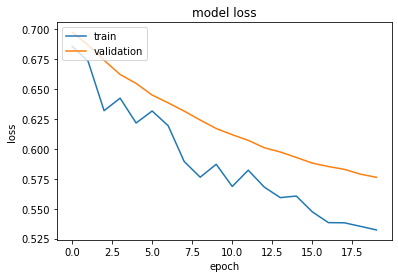

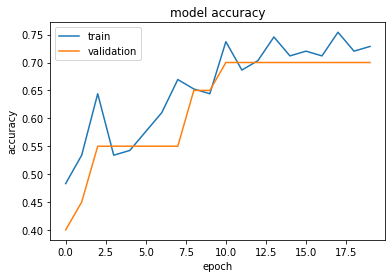

In [6]:
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(56, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output - Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
model.compile(
 optimizer = 'sgd',
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

all_features = ['A1','xA1','cA1','vA1','bA1','nA1','mA1', 'A2','xA2',\
       'cA2','vA2','bA2','nA2','mA2', 'B1', 'xB1','cB1','vB1','bB1','nB1','mB1', \
        'B2','xB2','cB2','vB2','bB2','nB2','mB2',\
       'C1','xC1','cC1','vC1','bC1','nC1','mC1',\
       'C2','xC2','cC2','vC2','bC2','nC2','mC2', \
        'D1','xD1','cD1','vD1','bD1','nD1','mD1',\
       'D2','xD2','cD2','vD2','bD2','nD2','mD2']

subset = all_features
X = df2[subset].values.tolist() 
Y = df2[['labels']].values.tolist()

X = np.array(X)
Y = [y[0] for y in Y]

# Selecting samples from specific classes. i.e label==1 or label==4 selects samples
# from Late Lactation and Peak Lactation classes.
X_new_2c, y_2 = [], []
for sample, label in zip(X,Y):
    if (label==1)  or (label==4):
        X_new_2c.append(sample)
        y_2.append(label)

# Splitting to training, validation and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_new_2c, y_2, test_size=0.25,stratify=y_2)
X_test, final_x_test, y_test, final_y_test = train_test_split(X_test, y_test, test_size=0.5,stratify=y_test)

# Data transformation and normalization
stage = 4
y_train = binarize_classes(y_train,stage)
y_test = binarize_classes(y_test,stage)
final_y_test = binarize_classes(final_y_test,stage)

y_train = np.array(y_train)
y_train = np.ravel(y_train)
y_test = np.array(y_test)
y_test = np.ravel(y_test)
final_y_test= np.array(final_y_test)
final_y_test= np.ravel(final_y_test)

# Data normalization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_TR = scaler.transform(X_train)
X_test_TR = scaler.transform(X_test)
final_x_test_TR = scaler.transform(final_x_test)

# Train the model
epochs = 20
batch_size = 14
results = model.fit(
    X_train_TR, y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (X_test_TR, y_test)
)

# Validation set
print("-----Validation set------")
print("Validation Accuracy: ", results.history["val_accuracy"][-1])

pred = model.predict(X_test_TR)
rounded = []
for p in pred:
    rounded.append(np.round(p))
print(classification_report(y_test, rounded))

# Test set
print("-----Unseen test set predictions------")
pred = model.predict(final_x_test_TR)
rounded = []
for p in pred:
    rounded.append(np.round(p))

print(classification_report(final_y_test, rounded))

cf = confusion_matrix(final_y_test, rounded)
print("Confusion Matrix of unseen test set: \n", cf)

model_name = 'late_peak_lactation'+ "_ep_"+ str(epochs) + "_bss_"+str(batch_size) 

# "Loss"
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_valloss_'+model_name+'.png', dpi=600)
plt.show()

#  "Accuracy"
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_vallacc_'+model_name+'.png', dpi=600)
plt.show()